
# **Fine-tuning XLS-R for Hindi**

*Acknowledgements :This notebook could not have been possible without the help of my mentor Abid Ali Awan who guided me throughout the course of my learning journey and the Kagglex Mentorship Program team .*

 Introduction

Automatic Speech Recognition (ASR) technology has revolutionized the way we interact with machines and devices. With the increasing popularity of voice-enabled applications and services, the demand for accurate and efficient ASR systems has grown significantly.  this project focuses on developing an ASR model specifically for the Hindi language, aiming to enable seamless voice-based interactions and services for Hindi speakers.

# Objective and Motivation

The primary objective of this project is to build a robust and accurate ASR system that can effectively transcribe spoken Hindi into text.The motivation behind creating an ASR system for the Hindi language stems from the need to bridge the gap between technology and the diverse linguistic communities in India. Hindi, being one of the most widely spoken languages in the country, deserves a robust voice recognition system that can cater to the needs of millions of native speakers. 

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/xls_r.png)




<div>
  <div style="float:left; width:70%;">
    <!-- Your text here -->
    <p>
      <h2>Project Workflow</h2>

 <h3>Data Preparation</h3>

- Set up the notebook environment and load the dataset, filtering based on votes.
- Standardize file paths from ".mp3" to ".wav" format. See [File Conversion Notebook](https://www.kaggle.com/code/sakshirathi77/cv15-hindi-mp3-to-wav-dataset-kagglex?kernelSessionId=146652760).
- Split the dataset into training and testing sets, removing unnecessary columns.
- Apply text normalization techniques to ensure consistent formatting.
- Create a comprehensive vocabulary, including special tokens for improved coverage.
<h3> Model Setup
</h3>
- Create and upload a Wav2VecCTCTokenizer to the Hugging Face model hub.
- Initialize Wav2VecFeatureExtractors for efficient data preprocessing.
- Develop a function to convert speech files to arrays, resampling them to a standardized sampling rate.

<h3>Training & Evaluation</h3>

- Train the model using DataCollatorCTC with padding for effective data management.
- Evaluate model performance using Word Error Rate (WER) and Character Error Rate (CER) metrics in the [Evaluation Notebook].("")
- Push the trained model to the Hugging Face model hub for easy accessibility and sharing.</p>
  </div>
  <div style="float:right; width:30%;">
    <!-- Your image here -->
<!--     <img src="https://thedigitalprojectmanager.b-cdn.net/wp-content/uploads/2022/03/a-complete-guide-to-workflow-diagrams-for-project-managers-featured-image-1200x630.png" > -->
    <img src="https://assets.plan.io/images/blog/what-is-a-workflow.png" >
  </div>
</div>


## Notebook Setup

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
%%capture
!pip install jiwer
!apt install git-lfs

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("hugging_face")

In [ ]:
!huggingface-cli login --token $secret_value_0

## Prepare Data, Tokenizer, Feature Extractor

### Data Processing and Vocabulary Creation
![vocabulary image](https://www.wikihow.com/images/thumb/6/6c/Learn-Hindi-Step-1-Version-4.jpg/v4-460px-Learn-Hindi-Step-1-Version-4.jpg.webp)


In [ ]:
from datasets import load_dataset, load_metric,Dataset,Audio
from datasets import set_caching_enabled
set_caching_enabled(False)
import pandas as pd


df =pd.read_csv("/kaggle/input/cv15-hindi/hi/hi/train.tsv", sep='\t', header=0)
df["votes"] = df["up_votes"]-df["down_votes"]
df = df[df["votes"]>=2]
df["path"]=df["path"].str.replace(".mp3",".wav")


In [ ]:
from sklearn.model_selection import train_test_split
df["path"] = "/kaggle/input/cv15-hindi/audio_wav_16000/tmp/CV15_ASR_dataset/audio_wav_16000/"+df["path"] ## Adding the absolute path to the audio files in the DataFrame
df.rename(columns = {'transcription':'sentence'}, inplace = True)
train,test = train_test_split(df, test_size=0.1, random_state=42)
common_voice_train = Dataset.from_pandas(train[0:2000])
common_voice_test = Dataset.from_pandas(test)

In [ ]:
common_voice_train = common_voice_train.remove_columns(['client_id', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment', 'votes', '__index_level_0__'])
common_voice_test = common_voice_test.remove_columns(['client_id', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment', 'votes', '__index_level_0__'])

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(common_voice_train.remove_columns(["path"]), num_examples=10)

In [ ]:
import re
import unicodedata

def normalize_text(batch):
    """DO ADAPT FOR YOUR USE CASE. this function normalizes the target text."""

    chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\’\'\|\&\–]'  
    remove_en = '[A-Za-z]'
    batch["sentence"] = re.sub(chars_to_ignore_regex, "", batch["sentence"].lower())
    batch["sentence"] = re.sub(remove_en, "", batch["sentence"]).lower()
    batch["sentence"] = unicodedata.normalize("NFKC", batch["sentence"])
    token_sequences_to_ignore = ["\n\n", "\n", "   ", "  "]

    for t in token_sequences_to_ignore:
        batch["sentence"] = " ".join(batch["sentence"].split(t))

    return batch

In [ ]:
common_voice_train = common_voice_train.map(normalize_text)
common_voice_test = common_voice_test.map(normalize_text)

In [ ]:
show_random_elements(common_voice_train.remove_columns(["path"]))

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

In [ ]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
vocab_dict

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

In [ ]:
import json

with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

### Create `Wav2Vec2CTCTokenizer`

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [ ]:
repo_name = "wav2vec2-large-xlsr-300m-hi-kagglex"
tokenizer.push_to_hub(repo_name)

### Create `Wav2Vec2FeatureExtractor`

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
%cd /root/.cache/huggingface/datasets/common_voice/tr/6.1.0/5693bfc0feeade582a78c2fb250bc88f52bd86f0a7f1bb22bfee67e715de30fd 
!dir

In [ ]:
import soundfile as sf
import torchaudio

def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = sf.read(batch["path"])
    batch["speech"] = speech_array
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["sentence"]
    return batch

In [ ]:
common_voice_train = common_voice_train.map(speech_file_to_array_fn, remove_columns=common_voice_train.column_names,num_proc=4)
common_voice_test = common_voice_test.map(speech_file_to_array_fn, remove_columns=common_voice_test.column_names,num_proc=4)

In [ ]:
import librosa
import numpy as np
def resample(batch):
    batch["speech"] = librosa.resample(np.asarray(batch["speech"]), 48_000, 16_000)
    batch["sampling_rate"] = 16_000
    return batch

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(common_voice_train)-1)

ipd.Audio(data=np.asarray(common_voice_train[rand_int]["speech"]), autoplay=True, rate=16000)

In [ ]:
rand_int = random.randint(0, len(common_voice_train)-1)

print("Target text:", common_voice_train[rand_int]["target_text"])
print("Input array shape:", np.asarray(common_voice_train[rand_int]["speech"]).shape)
print("Sampling rate:", common_voice_train[rand_int]["sampling_rate"])

In [ ]:
def prepare_dataset(batch):
    

    # batched output is "un-batched"
    batch["input_values"] = processor(batch["speech"], sampling_rate=16_000).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [ ]:
common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names)
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names)

## Training Setup



In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

### Load Evaluation Metrics

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer,"cer": cer}

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)

In [ ]:
model.freeze_feature_extractor()

### Training Configuration

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=32,
  gradient_accumulation_steps=4,
  evaluation_strategy="steps",
  num_train_epochs=100,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=300,
  eval_steps=300,
  logging_steps=300,
  learning_rate=1e-4,
  warmup_steps=300,
  save_total_limit=2,
  push_to_hub=True,
  report_to="none"
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,

)

### Training and Uploading on huggingface

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub()

# Evaluation

This model is a fine-tuned version of facebook/wav2vec2 on the Common Voice 15 dataset. It achieves the following results on the evaluation set:

Loss: 0.3691

Wer: 0.3285

Cer: 0.0875

For more information,
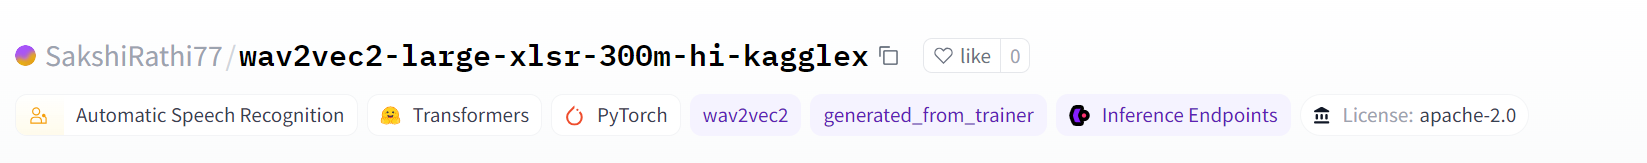


you can check the [Evaluation Notebook](https://www.kaggle.com/code/sakshirathi77/whisper-hindi-evaluation-kagglex/edit)

These metrics showcase the model's efficiency and accuracy in transcribing diverse Hindi speech patterns and linguistic intricacies, underscoring its robustness and reliability in capturing the nuances of the language.

# Conclusion
The Wav2Vec2 model, following fine-tuning on the Hindi dataset, demonstrates exceptional capabilities in accurately transcribing Hindi speech data. Its competitive metrics, coupled with its robust architecture, signify its potential for addressing the challenges of Hindi speech recognition, thereby contributing significantly to advancements in the field of Automatic Speech Recognition for the Hindi language.

**Hugging Face Space Link**: [Hugging Face Space](https://huggingface.co/spaces/SakshiRathi77/SakshiRathi77-Wav2Vec2-hi-kagglex)

**Trained ASR Model**: [Trained ASR Model](https://huggingface.co/SakshiRathi77/wav2vec2-large-xlsr-300m-hi-kagglex/tree/main)

# References

[Fine-Tune Wav2Vec2 for English ASR with 🤗 Transformers](https://huggingface.co/blog/fine-tune-wav2vec2-english)<br>
[Colab Notebook](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_tuning_Wav2Vec2_for_English_ASR.ipynb)

